**Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion



### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data Reading/Data Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory uti

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

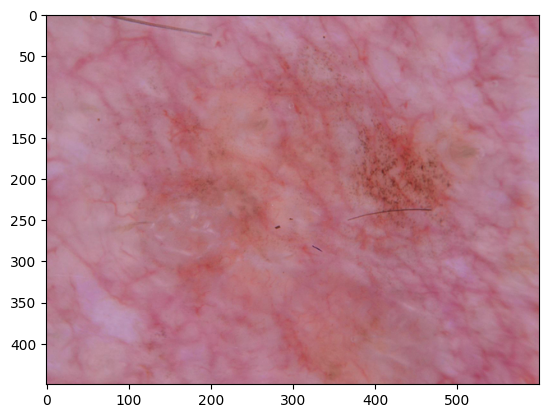

In [11]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

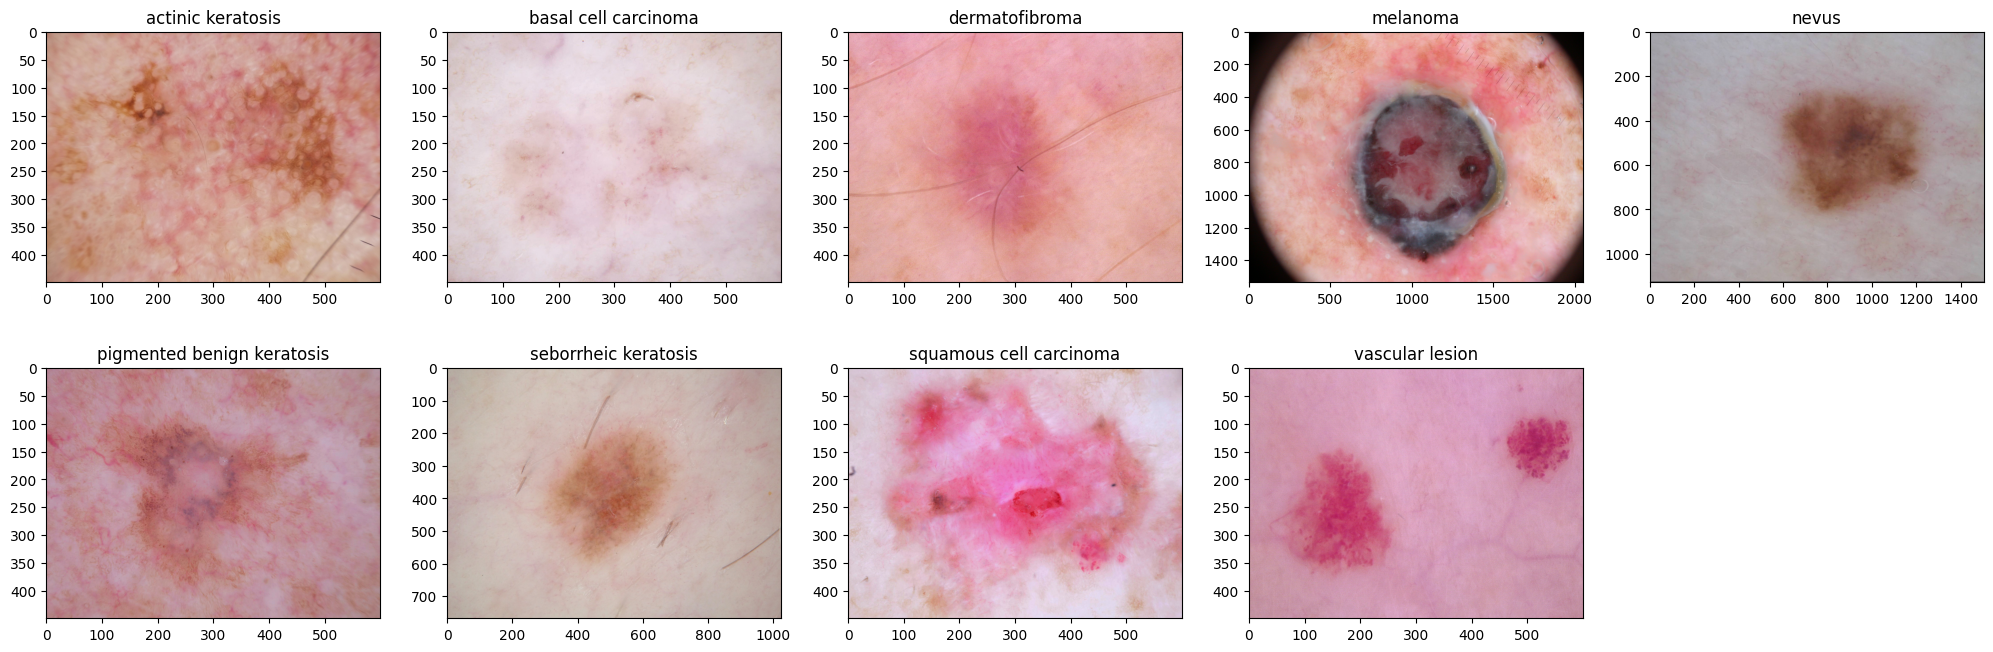

In [12]:
#Visualizing images of all classes
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_metrics_of_cnn(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Model Building and Training
* Create a CNN model, which can accurately detect 9 classes present in the dataset.
* Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1).
* The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [15]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.2146 - loss: 7.0852 - val_accuracy: 0.3602 - val_loss: 1.8430
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.3696 - loss: 1.7514 - val_accuracy: 0.4743 - val_loss: 1.5811
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4853 - loss: 1.4532 - val_accuracy: 0.5056 - val_loss: 1.5021
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5284 - loss: 1.3131 - val_accuracy: 0.4564 - val_loss: 1.5926
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5854 - loss: 1.2287 - val_accuracy: 0.5369 - val_loss: 1.4986
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.6277 - loss: 1.0280 - val_accuracy: 0.5369 - val_loss: 1.5731
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6440 - loss: 0.9644 - val_accuracy: 0.5168 - val_loss: 1.7026
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7046 - loss: 0.8364 - val_accuracy: 0.4989 - v

### Visualizing training results

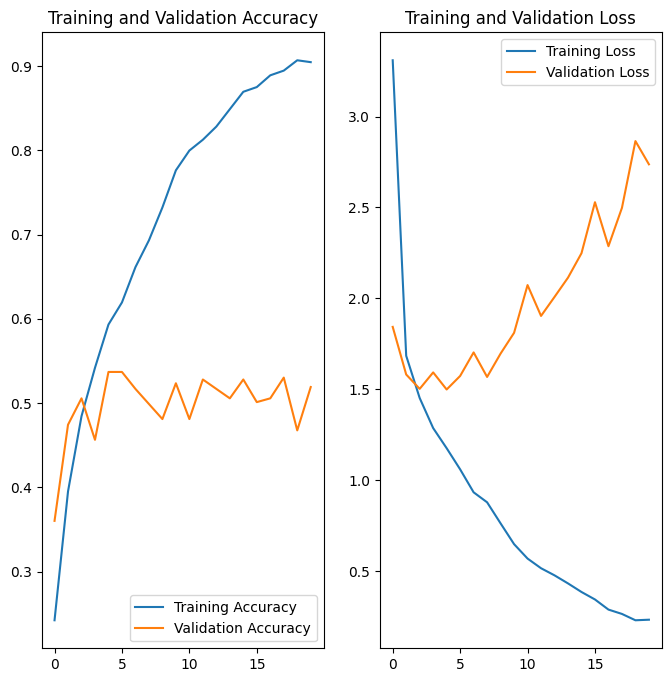

In [21]:
# Visualizing training results
plot_metrics_of_cnn(history,epochs)

### Observations

- The visual representation of the model's performance indicates a substantial discrepancy between the training accuracy and validation accuracy, achieving a validation accuracy of around 51%

- The model's training accuracy displays a linear increase over time, whereas the validation accuracy plateaus are at 51% accuracy during the training process.

- As the training epochs progress, the training loss decreases, however, the validation loss exhibits an opposing trend and increases.

- The noticeable difference between the training accuracy(80%) and validation accuracy(52%) is a clear indication of overfitting, indicating that the model may not generalize well to unseen data.

### Choosing an appropriate data augmentation strategy to resolve overfitting/underfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

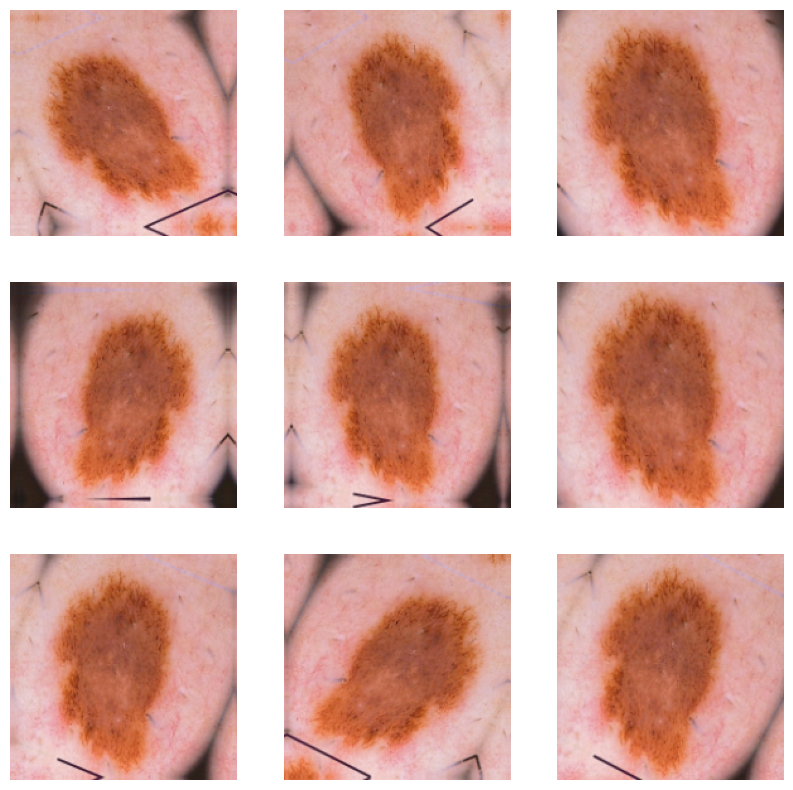

In [23]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model building and training on augmented Data:
### Create the model, compile and train the model


In [24]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compiling the model

In [25]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.2094 - loss: 5.3610 - val_accuracy: 0.4251 - val_loss: 1.7117
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.4028 - loss: 1.6773 - val_accuracy: 0.4474 - val_loss: 1.6052
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.4809 - loss: 1.5192 - val_accuracy: 0.4855 - val_loss: 1.4685
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5038 - loss: 1.4013 - val_accuracy: 0.5168 - val_loss: 1.4111
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.5256 - loss: 1.3929 - val_accuracy: 0.4474 - val_loss: 1.5776
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.4903 - loss: 1.4481 - val_accuracy: 0.4743 - val_loss: 1.5870
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5125 - loss: 1.3662 - val_accuracy: 0.4787 - val_loss: 1.5599
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.5269 - loss: 1.3458 - val_accuracy: 0

### Visualizing the results

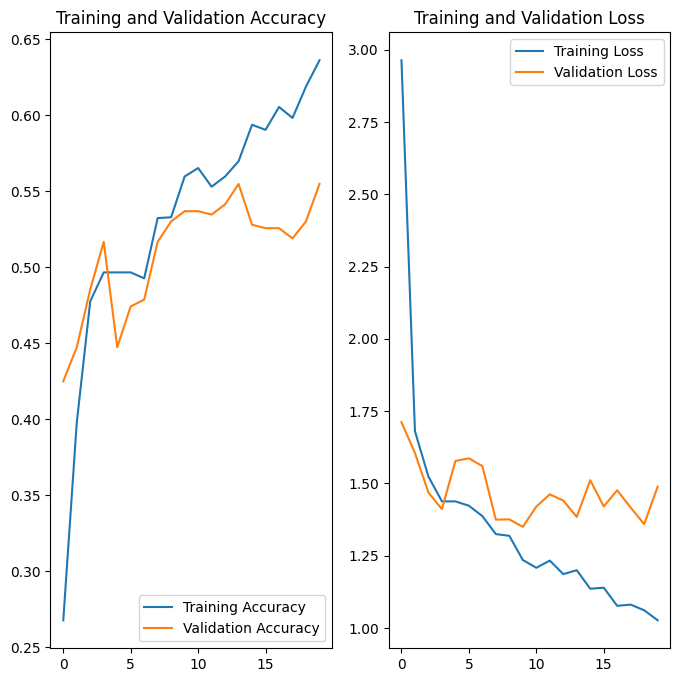

In [27]:
# Visualizing training results
plot_metrics_of_cnn(history,epochs)

### Observations:

* As the training accuracy increases linearly over time, where as the validation accuracy increases and stall around 55% accuracy in training process.

* As the training loss decreases with epochs the validation loss decreases and stalls.

* The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.

* The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.


### Model Building & training on the augmented data with dropout :



In [28]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [29]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.1637 - loss: 5.2672 - val_accuracy: 0.2975 - val_loss: 1.9687
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.3295 - loss: 1.8897 - val_accuracy: 0.3848 - val_loss: 1.6784
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.3995 - loss: 1.6731 - val_accuracy: 0.4004 - val_loss: 1.7962
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.4534 - loss: 1.5874 - val_accuracy: 0.4989 - val_loss: 1.4782
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.5191 - loss: 1.3981 - val_accuracy: 0.4698 - val_loss: 1.6921
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.4882 - loss: 1.4510 - val_accuracy: 0.4183 - val_loss: 1.5912
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.4624 - loss: 1.4919 - val_accuracy: 0.4922 - val_loss: 1.4850
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5062 - loss: 1.3637 - val_accuracy: 

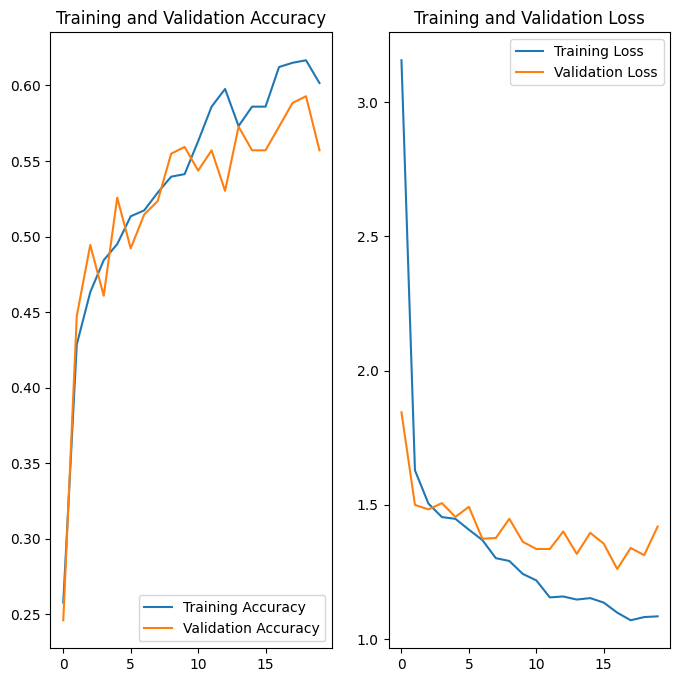

In [32]:
# Visualizing training results
plot_metrics_of_cnn(history,epochs)

### Observation


* As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process at the last epoch it can be seen that it reached 56%

* The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 56% accuracy on the validation set.

* The difference in accuracy between training and validation accuracy is very less

* **As the training loss decreases with epochs the validation loss decreases**


**We can clearly see that the overfitting of the model has reduced significantly when compared with the earlier models**

### **Class distribution:**

####  Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### **Findings**:

#### - Which class has the least number of samples?
       seborrheic keratosis with only 77 samples.

#### - Which classes dominate the data in terms proportionate number of samples?
       pigmented benign keratosis which has 462 samples.

### Rectifying the class imbalance

##### Using python package `Augmentor`

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [48]:
path_to_training_dataset = os.path.abspath("/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
import Augmentor
for i in class_names:
    source_path = os.path.join(path_to_training_dataset, i)
    output_path = os.path.join("/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/",i+"/")
    p = Augmentor.Pipeline(source_directory=source_path, output_directory=output_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0590300490>: 100%|██████████| 500/500 [00:20<00:00, 24.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B059044AC50>: 100%|██████████| 500/500 [00:18<00:00, 26.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B05903033A0>: 100%|██████████| 500/500 [00:20<00:00, 24.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7B05AEC37C10>: 100%|██████████| 500/500 [01:17<00:00,  6.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/nevus/.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7B051E6B94B0>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B051E5A4EB0>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/seborrheic keratosis/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B05AEC35990>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0590302E90>: 100%|██████████| 500/500 [00:19<00:00, 25.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0522BC19F0>: 100%|██████████| 500/500 [00:20<00:00, 24.35 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/output/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [50]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [51]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [52]:
df['Label'].value_counts()

,count
Label,
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [53]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [54]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### Create a validation dataset

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### Model Building & training on the rectified class imbalance data :


* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [56]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [57]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Train your model

In [58]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 237ms/step - accuracy: 0.1928 - loss: 5.2866 - val_accuracy: 0.2967 - val_loss: 1.9171
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - accuracy: 0.3955 - loss: 1.5915 - val_accuracy: 0.3833 - val_loss: 1.6238
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.4535 - loss: 1.4908 - val_accuracy: 0.3944 - val_loss: 1.5448
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.4644 - loss: 1.4115 - val_accuracy: 0.4489 - val_loss: 1.4404
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.4670 - loss: 1.3656 - val_accuracy: 0.5089 - val_loss: 1.3140
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 265ms/step - accuracy: 0.5186 - loss: 1.2779 - val_accuracy: 0.4911 - val_loss: 1.3812
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.5214 - loss: 1.2736 - val_accuracy: 0.4844 - val_loss: 1.3330
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.5455 - loss: 1

#### Visualize the model results

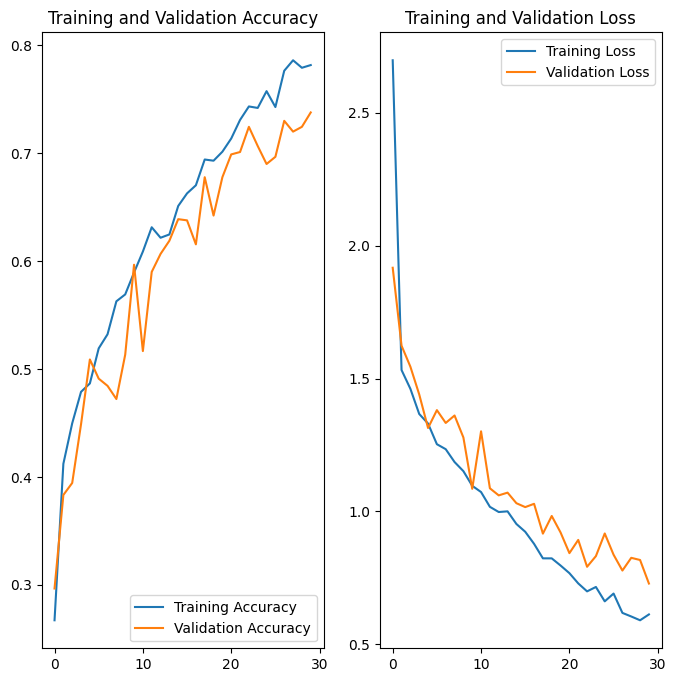

In [59]:
# Visualizing model results
plot_metrics_of_cnn(history,epochs)

#### Observations:

1. As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
2. As the training loss decreases with epochs the validation loss also decreases.
3. The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 73% accuracy on the validation set.
4. The difference in accuracy between training and validation accuracy is very less



### Summary of Accuracies and Losses:

| Method | Training Accuracy | Training Loss | Validation Accuracy | Validation Loss |
| ------- | ---------------- | --------------| ------------------- | --------------- |
| CNN Model | 0.8996 | 0.2246 |  0.5190 | 2.7372 |
| CNN + Data Augmentation Stratergy | 0.6248 | 1.0350 | 0.5548 | 1.4889 |
| CNN + Data Augmentation Stratergy + Dropout | 0.6246 | 1.0608 |0.5638 | 1.3634 |
| Rectifying class Imbalance + CNN + Dropout | 0.7756 | 0.6020 | 0.7378 | 0.7286 |